# Libraries

In [1]:
import os, csv, math, time, glob
import argparse
from pathlib import Path
import numpy as np
import cv2 
from tqdm import tqdm
import mediapipe as mp
from collections import Counter, defaultdict
import json
from collections import deque
import shutil

# Data Preprocessing

In [2]:
# Paths
DATASET_DIR = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\Videos"  # input dataset directory (with subdirs per class)
REPORT_CSV  = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\video_audit.csv" # output CSV report path

# Optional quick centering check (uses MediaPipe Pose on a few frames)
DO_CENTERING_CHECK = False   # set True to enable (slower)
SAMPLE_FRAMES_PER_VIDEO = 20
CENTER_BOX_W, CENTER_BOX_H = 1156, 866   # reference “central box” size (can be any you like)
CENTER_MARGIN_PX = 20                    # require landmarks to be at least this far from box edges

# OPTIONAL: Pose landmark helper 
if DO_CENTERING_CHECK:
    import mediapipe as mp
    mp_pose = mp.solutions.pose
    POSE_IDXS = [0, 11, 12, 13, 14, 15, 16]  # nose, L/R shoulder, L/R elbow, L/R wrist

    def pct_frames_landmarks_in_center(frame_reader, w, h):
        # Sample frames and check if pose landmarks lie within a centered box of size CENTER_BOX_W x CENTER_BOX_H.
        box_w, box_h = min(CENTER_BOX_W, w), min(CENTER_BOX_H, h)
        x0 = (w - box_w) // 2
        y0 = (h - box_h) // 2
        x1, y1 = x0 + box_w, y0 + box_h

        success = 0
        total = 0
        with mp_pose.Pose(static_image_mode=False, model_complexity=0) as pose:
            for frame in frame_reader():
                total += 1
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                res = pose.process(rgb)
                ok = False
                if res.pose_landmarks:
                    ok = True
                    for idx in POSE_IDXS:
                        lm = res.pose_landmarks.landmark[idx]
                        x_px = lm.x * w
                        y_px = lm.y * h
                        if not (x0 + CENTER_MARGIN_PX <= x_px <= x1 - CENTER_MARGIN_PX and
                                y0 + CENTER_MARGIN_PX <= y_px <= y1 - CENTER_MARGIN_PX):
                            ok = False
                            break
                if ok: success += 1
        return (success / total * 100.0) if total else 0.0

In [3]:
# Main processing
rows = []
per_class_res = defaultdict(Counter)
per_class_fps = defaultdict(Counter)

def fourcc_to_str(v):
    try:
        return "".join([chr((int(v) >> 8 * i) & 0xFF) for i in range(4)])
    except:
        return "unknown"

classes = [d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))]
classes.sort()

for cls in classes:
    in_dir = os.path.join(DATASET_DIR, cls)
    videos = [f for f in os.listdir(in_dir) if f.lower().endswith((".mp4",".avi",".mov",".mkv",".m4v",".webm"))]
    videos.sort()
    for vf in videos:
        path = os.path.join(in_dir, vf)
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            print(f"[WARN] Cannot open: {path}")
            continue

        w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
        nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # duration estimation (fallback if fps=0)
        duration = (nframes / fps) if (fps and fps > 0) else float("nan")

        fourcc_val = cap.get(cv2.CAP_PROP_FOURCC)
        codec = fourcc_to_str(fourcc_val)

        # Optional: sample frames generator for pose check
        centering_pct = ""
        if DO_CENTERING_CHECK and nframes > 0:
            # Choose SAMPLE_FRAMES_PER_VIDEO evenly spaced indices
            idxs = list({int(i) for i in np.linspace(0, max(0, nframes-1), num=min(SAMPLE_FRAMES_PER_VIDEO, nframes))})  # unique
            idxs.sort()

            def reader():
                for idx in idxs:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                    ok, frame = cap.read()
                    if ok: yield frame

            import numpy as np
            centering_pct = round(pct_frames_landmarks_in_center(reader, w, h), 2)
            # reset to beginning for clean close
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

        cap.release()

        res_str = f"{w}x{h}"
        per_class_res[cls][res_str] += 1

        # Round fps to two decimals for grouping
        fps_round = round(float(fps), 2) if math.isfinite(fps) else 0.0
        per_class_fps[cls][fps_round] += 1

        rows.append({
            "class": cls,
            "video": vf,
            "path": path,
            "width": w,
            "height": h,
            "resolution": res_str,
            "fps": fps_round,
            "frame_count": nframes,
            "duration_sec": round(duration, 3) if math.isfinite(duration) else "",
            "codec": codec,
            "aspect_ratio": round(w / h, 5) if h else "",
            "center_check_pct_in_box": centering_pct  # empty string if disabled
        })

In [4]:
# Write CSV report
os.makedirs(os.path.dirname(REPORT_CSV), exist_ok=True)
with open(REPORT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()) if rows else
                            ["class","video","path","width","height","resolution","fps","frame_count","duration_sec","codec","aspect_ratio","center_check_pct_in_box"])
    writer.writeheader()
    writer.writerows(rows)

# Print summary statistics
print("\nUNIQUE RESOLUTIONS PER CLASS ")
for cls in classes:
    cnt = per_class_res[cls]
    if not cnt: continue
    total = sum(cnt.values())
    common, common_n = cnt.most_common(1)[0]
    print(f"{cls}: {dict(cnt)} | most common = {common} ({common_n}/{total})")

print("\nUNIQUE FPS PER CLASS ")
for cls in classes:
    cnt = per_class_fps[cls]
    if not cnt: continue
    total = sum(cnt.values())
    common, common_n = cnt.most_common(1)[0]
    print(f"{cls}: {dict(cnt)} | most common = {common} fps ({common_n}/{total})")

# Flag videos not matching their class's most-common resolution or FPS
print("\nINCONSISTENCIES (by class majority)")
res_major = {cls: (per_class_res[cls].most_common(1)[0][0] if per_class_res[cls] else None) for cls in classes}
fps_major = {cls: (per_class_fps[cls].most_common(1)[0][0] if per_class_fps[cls] else None) for cls in classes}

bad = []
for r in rows:
    mismatches = []
    if res_major[r["class"]] and r["resolution"] != res_major[r["class"]]:
        mismatches.append(f"res {r['resolution']} != {res_major[r['class']]}")
    if fps_major[r["class"]] is not None and r["fps"] != fps_major[r["class"]]:
        mismatches.append(f"fps {r['fps']} != {fps_major[r['class']]}")
    if mismatches:
        bad.append((r["class"], r["video"], "; ".join(mismatches)))

if bad:
    for cls, vid, why in bad:
        print(f"[{cls}] {vid}: {why}")
else:
    print("No resolution/FPS mismatches found within each class.")

print(f"\nReport saved to: {REPORT_CSV}")


UNIQUE RESOLUTIONS PER CLASS 
Don't Understand: {'640x360': 21} | most common = 640x360 (21/21)
Good Afternoon: {'640x360': 21} | most common = 640x360 (21/21)
Good Evening: {'640x360': 22} | most common = 640x360 (22/22)
Good Morning: {'640x360': 20} | most common = 640x360 (20/20)
Hello: {'640x360': 20} | most common = 640x360 (20/20)

UNIQUE FPS PER CLASS 
Don't Understand: {60.0: 21} | most common = 60.0 fps (21/21)
Good Afternoon: {60.0: 21} | most common = 60.0 fps (21/21)
Good Evening: {60.0: 22} | most common = 60.0 fps (22/22)
Good Morning: {60.0: 20} | most common = 60.0 fps (20/20)
Hello: {60.0: 20} | most common = 60.0 fps (20/20)

INCONSISTENCIES (by class majority)
No resolution/FPS mismatches found within each class.

Report saved to: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\video_audit.csv


As can be seen, every video has the same resolution of 640x360 pixels and their frames per second is 60 fps. This verifications means that our data is clean and be extracted. Their duration is also 4.067 per video with frame count of 244. 
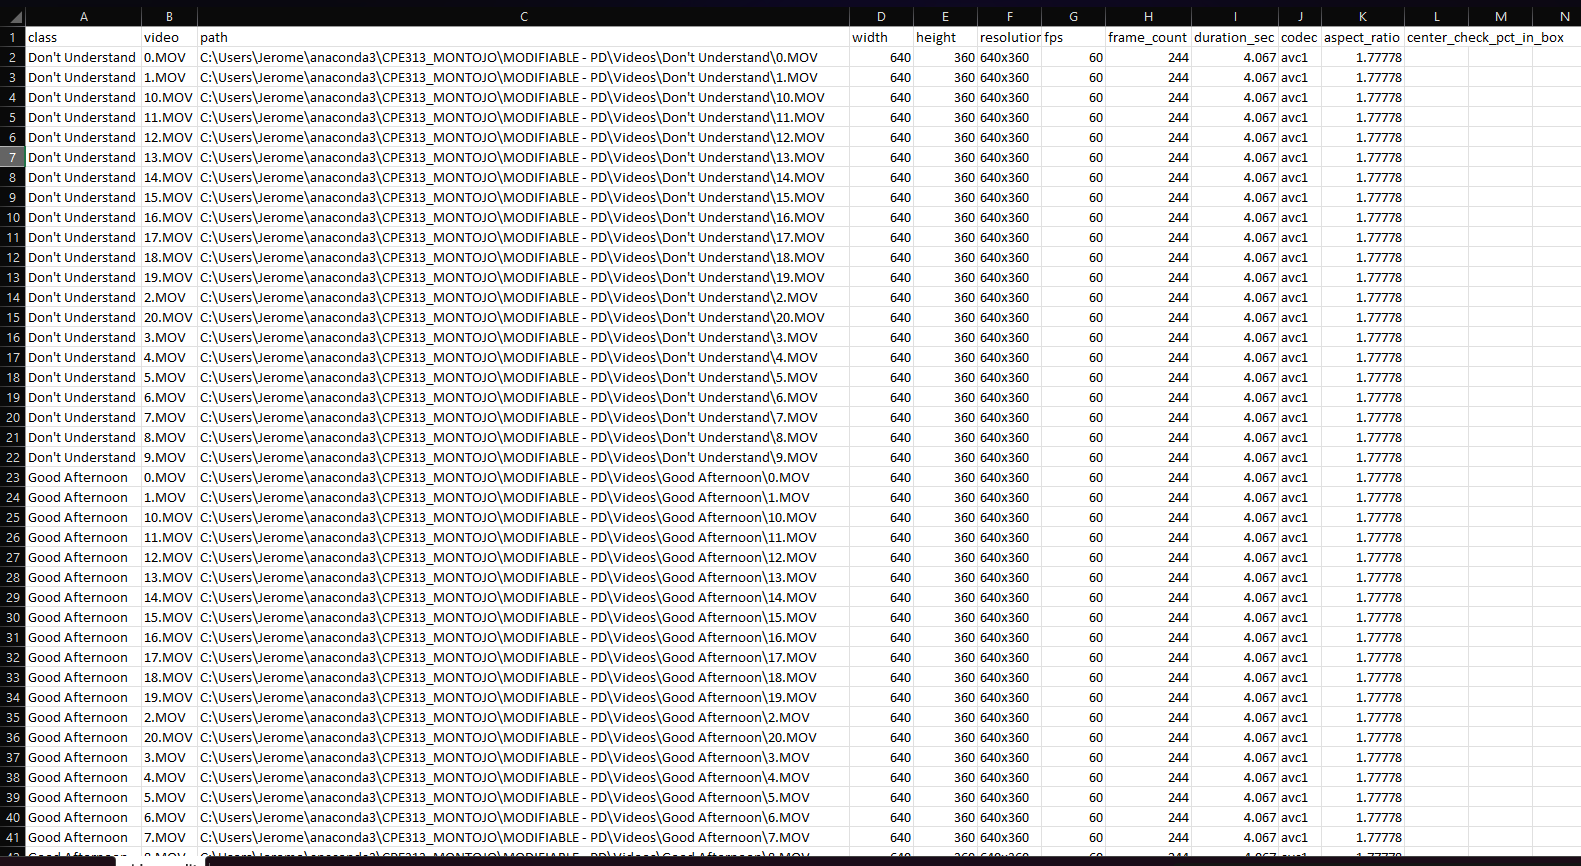

# MediaPipe Holistic 

## NEW VERSION

In [5]:
DATASET_DIR = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\Videos"   # per-class folders
OUTPUT_DIR  = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS" # per-video .npy
os.makedirs(OUTPUT_DIR, exist_ok=True)
actions = ["Good Morning", "Good Afternoon", "Good Evening", "Hello", "Don't Understand"] # Current gestures

SEQUENCE_LENGTH = 48 # number of frames per sequence (N)
APPEND_FLAGS = True # append [left_present, right_present] to feature vector
FEATURE_DIM = 126 + (2 if APPEND_FLAGS else 0)
USE_HANDS_ONLY = True # if True, only use hand landmarks (no pose/face)
MIN_DET_CONF = 0.7 # min detection confidence to accept
MIN_TRACK_CONF = 0.7 # min tracking confidence to accept
MODEL_COMPLEXITY = 1 # 0, 1, or 2 (higher = slower, more accurate)
FRAME_STRIDE = 1 # process every Nth frame (1=all, 2=every other, etc)     
MIN_PALM_SCALE = 0.02 # min palm size (as fraction of frame height) to accept hand detection
CLIP_COORD = 5.0 # clip landmark coords to +/- this value (to catch bad outliers)
MAX_CARRY_FRAMES = 0   # carry-forward only for short gaps
CARRY_NOISE_STD  = 0.0  # tiny noise to avoid frozen-copy bias
SKIP_EMPTY_VIDS = True # skip videos with no detections
MIN_DET_RATIO   = 0.20   
OVERWRITE       = True # overwrite existing .npy files
INVERT_HANDEDNESS = True # swap left/right hands
np.random.seed(42)

In [6]:
# Helpers for sampling frames
def normalize_hand(pts: np.ndarray) -> np.ndarray:
    if pts is None or pts.shape != (21,3):
        return np.zeros((21,3), np.float32)
    wrist, mid = pts[0], pts[9]
    scale = float(np.linalg.norm(mid[:2] - wrist[:2]))
    if not np.isfinite(scale) or scale < MIN_PALM_SCALE:
        scale = MIN_PALM_SCALE
    out = (pts - wrist) / scale
    return np.clip(out, -CLIP_COORD, CLIP_COORD).astype(np.float32)

def pack_feature(L_pts, R_pts, lf, rf) -> np.ndarray:
    L = normalize_hand(L_pts)
    R = normalize_hand(R_pts)
    feat = np.concatenate([L.reshape(-1), R.reshape(-1)], axis=0)
    if APPEND_FLAGS:
        feat = np.concatenate([feat, np.array([lf, rf], dtype=np.float32)], axis=0)
    return feat.astype(np.float32)

def split_coords_flags(seq: np.ndarray):
    """seq: (T, D). Returns coords (T,42,3) and flags (T,2)."""
    T, D = seq.shape
    coords = seq[:, :126].reshape(T, 42, 3)
    if D >= 128:
        flags = seq[:, 126:128]
    else:
        flags = np.zeros((T, 2), dtype=np.float32)
    return coords, flags

def combine_coords_flags(coords: np.ndarray, flags: np.ndarray) -> np.ndarray:
    """coords: (T,42,3), flags: (T,2) -> (T, 126 or 128)"""
    T = coords.shape[0]
    feat = coords.reshape(T, 126)
    if APPEND_FLAGS:
        feat = np.concatenate([feat, flags.astype(np.float32)], axis=1)
    return feat.astype(np.float32)

def _motion_mag(coords: np.ndarray) -> np.ndarray:
    """coords: (T,42,3) -> motion magnitude per transition (T-1,)"""
    v = np.diff(coords, axis=0)
    return np.linalg.norm(v, axis=(1, 2))

def trim_idle_edges(coords: np.ndarray, flags: np.ndarray, max_idle_edge=12, eps=5e-4):
    """Trim long low-motion stretches at start/end, independent of flags."""
    T = coords.shape[0]
    if T <= 2:
        return coords, flags
    v = np.diff(coords, axis=0)
    m = np.linalg.norm(v, axis=(1, 2))           # (T-1,)
    m_full = np.r_[m[0], m, m[-1]] if len(m) > 1 else np.zeros(T, dtype=np.float32)
    active_idx = np.where(m_full > eps)[0]
    if len(active_idx) == 0:
        single = coords[-1:][:1]
        return np.repeat(single, repeats=min(T, 1), axis=0), flags[: min(T, 1)]
    start = max(0, active_idx[0] - 1)
    end   = min(T, active_idx[-1] + 1)
    if start > max_idle_edge: start = max_idle_edge
    if (T - end) > max_idle_edge: end = T - max_idle_edge
    end = max(end, start + 1)
    return coords[start:end], flags[start:end]

def _tail_is_frozen(coords: np.ndarray, k=6, eps=5e-4) -> bool:
    """Return True if the last k frames are effectively not moving."""
    k = min(k, coords.shape[0]-1) if coords.shape[0] > 1 else 1
    tail = coords[-(k+1):]
    diffs = np.abs(np.diff(tail, axis=0)).mean()
    return bool(diffs < eps)

def _defrost_tail(coords: np.ndarray, strength=0.25):
    """
    Nudge the last ~0.25T segment by blending with a gentle slope so it's not perfectly constant.
    """
    T = coords.shape[0]
    if T < 4: 
        return coords
    seg = max(3, int(T * strength))
    a0 = T - seg
    a1 = T - 1
    if a0 >= a1:
        return coords
    # create a tiny linear ramp over the last seg frames
    ramp = np.linspace(0.0, 1.0, seg, dtype=np.float32)[:, None, None]
    # target direction = mean velocity of the last active third (fallback if near-zero)
    mid0, mid1 = max(0, T//3), min(T-1, 2*T//3)
    mean_v = (coords[mid1] - coords[mid0]) / max(1, (mid1 - mid0))
    # very small amplitude so we don't distort the gesture
    coords[a0:T] = coords[a0:T] + 0.02 * ramp * mean_v
    return coords

def resample_to_length(coords: np.ndarray, flags: np.ndarray, target_len: int):
    """Linear resample coords to target_len; flags via nearest-neighbor to keep them binary-ish."""
    T = coords.shape[0]
    if T == target_len:
        return coords.astype(np.float32), flags.astype(np.float32)
    idx = np.linspace(0, T - 1, num=target_len)
    lo = np.floor(idx).astype(int)
    hi = np.clip(lo + 1, 0, T - 1)
    w  = (idx - lo)[:, None, None]  # (L,1,1)
    coords_out = (1 - w) * coords[lo] + w * coords[hi]
    flags_out  = flags[np.round(idx).astype(int)]
    return coords_out.astype(np.float32), flags_out.astype(np.float32)

EXTRA_TAIL_FRAMES = 5

def temporal_fix(seq: np.ndarray, target_len: int) -> np.ndarray:
    coords, flags = split_coords_flags(seq)

    # 1) trim idle edges
    coords, flags = trim_idle_edges(coords, flags, max_idle_edge=14, eps=3e-4)

    # 1b) keep a little quiet tail after last motion
    m = _motion_mag(coords)
    if m.size > 0 and m.max() > 0:
        m = m / m.max()
    tail_eps = 5e-4
    last_active = None
    for i in range(len(m)-1, -1, -1):
        if m[i] > tail_eps:
            last_active = i + 1
            break
    if last_active is not None:
        keep_upto = min(coords.shape[0], last_active + EXTRA_TAIL_FRAMES)
        coords = coords[:keep_upto]
        flags  = flags[:keep_upto]

    # 2) resample → 3) defrost if needed → 4) combine
    coords, flags = resample_to_length(coords, flags, target_len)
    if _tail_is_frozen(coords, k=6, eps=5e-4):
        coords = _defrost_tail(coords, strength=0.25)
    return combine_coords_flags(coords, flags)

In [7]:
# MediaPipe setup
mp_hands    = mp.solutions.hands
mp_holistic = mp.solutions.holistic

def get_detector():
    if USE_HANDS_ONLY:
        return mp_hands.Hands(static_image_mode=False,
                              max_num_hands=2,
                              model_complexity=MODEL_COMPLEXITY,
                              min_detection_confidence=MIN_DET_CONF,
                              min_tracking_confidence=MIN_TRACK_CONF)
    else:
        return mp_holistic.Holistic(static_image_mode=False,
                                    model_complexity=MODEL_COMPLEXITY,
                                    smooth_landmarks=True,
                                    refine_face_landmarks=False,
                                    min_detection_confidence=MIN_DET_CONF,
                                    min_tracking_confidence=MIN_TRACK_CONF,
                                    enable_segmentation=False)

def get_lr_pts(res, use_hands_only=True):
    """
    Return (L, R) as (21,3) arrays or None.
    Honors INVERT_HANDEDNESS for mirrored sources.
    """
    if res is None:
        return None, None

    if use_hands_only:
        # MediaPipe Hands path
        if not getattr(res, "multi_hand_landmarks", None):
            return None, None

        L, R = None, None
        handed = getattr(res, "multi_handedness", None)

        if handed and len(handed) == len(res.multi_hand_landmarks):
            # Use classifier labels when available
            for lm, hd in zip(res.multi_hand_landmarks, handed):
                label = hd.classification[0].label if hd.classification else "Right"
                if INVERT_HANDEDNESS:
                    label = "Left" if label == "Right" else "Right"

                pts = np.array([[p.x, p.y, p.z] for p in lm.landmark], dtype=np.float32)
                if label == "Left":
                    L = pts
                else:
                    R = pts
        else:
            # Deterministic fallback by index
            lms = res.multi_hand_landmarks
            if len(lms) >= 1:
                pts0 = np.array([[p.x, p.y, p.z] for p in lms[0].landmark], dtype=np.float32)
                if INVERT_HANDEDNESS:  # mirror means first becomes Left
                    L = pts0
                else:
                    R = pts0
            if len(lms) >= 2:
                pts1 = np.array([[p.x, p.y, p.z] for p in lms[1].landmark], dtype=np.float32)
                if INVERT_HANDEDNESS:
                    R = pts1
                else:
                    L = pts1

        return L, R

    # MediaPipe Holistic path (has explicit left/right landmarks)
    L = (np.array([[lm.x, lm.y, lm.z] for lm in res.left_hand_landmarks.landmark], dtype=np.float32)
         if getattr(res, "left_hand_landmarks", None) else None)
    R = (np.array([[lm.x, lm.y, lm.z] for lm in res.right_hand_landmarks.landmark], dtype=np.float32)
         if getattr(res, "right_hand_landmarks", None) else None)

    # Honor inversion toggle for mirrored sources
    if INVERT_HANDEDNESS:
        L, R = R, L

    return L, R

In [8]:
try:
    MAX_CARRY_FRAMES
except NameError:
    MAX_CARRY_FRAMES = min(4, SEQUENCE_LENGTH // 6)  # avoid long frozen repeats

try:
    CARRY_NOISE_STD
except NameError:
    CARRY_NOISE_STD = 0.003  # tiny jitter on coords when carrying last obs

# Main loop
for action in actions:
    src_dir = Path(DATASET_DIR, action)
    if not src_dir.is_dir():
        print(f"[warn] missing: {src_dir}"); 
        continue
    dst_dir = Path(OUTPUT_DIR, action); dst_dir.mkdir(parents=True, exist_ok=True)

    videos = sorted([p for p in src_dir.iterdir() if p.suffix.lower() in
                     (".mp4",".avi",".mov",".mkv",".mpg",".m4v",".webm")])

    with get_detector() as detector:
        for vp in tqdm(videos, desc=action):
            out_npy = dst_dir / f"{vp.stem}.npy"
            if not OVERWRITE and out_npy.exists():
                continue

            cap = cv2.VideoCapture(str(vp))
            if not cap.isOpened():
                print(f"[skip] cannot open {vp.name}")
                continue

            # [A] light diagnostics + stride tweak for very short clips
            total_est = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or -1
            if total_est == 1:
                print(f"[warn] {vp.name}: decoder reports 1 frame; consider re-encoding to MP4 (H.264, 30fps).")
            local_stride = FRAME_STRIDE if (total_est < 0 or total_est >= SEQUENCE_LENGTH) else 1

            seq = []
            det_frames = 0
            last_obs_feat = None
            carry_count = 0
            idx = 0

            # [B] simple counters for a friendly summary
            vid_frames = 0
            vid_processed = 0

            while True:
                ok, frame = cap.read()
                if not ok:
                    break
                vid_frames += 1

                if (idx % local_stride) != 0:
                    idx += 1
                    continue
                idx += 1

                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                rgb.flags.writeable = False

                # guard against occasional MP runtime exceptions
                try:
                    res = detector.process(rgb)
                except Exception:
                    res = None

                L_pts, R_pts = (None, None)
                if res is not None:
                    try:
                        L_pts, R_pts = get_lr_pts(res, use_hands_only=USE_HANDS_ONLY)
                    except Exception:
                        L_pts, R_pts = (None, None)

                lf = 1.0 if L_pts is not None else 0.0
                rf = 1.0 if R_pts is not None else 0.0
                detected = (lf + rf) > 0.0

                if detected:
                    feat = pack_feature(L_pts, R_pts, lf, rf)
                    last_obs_feat = feat
                    carry_count = 0
                    det_frames += 1
                else:
                    if (last_obs_feat is not None) and (carry_count < MAX_CARRY_FRAMES):
                        feat = last_obs_feat.copy()
                        if CARRY_NOISE_STD > 0:
                            noise = np.zeros_like(feat, dtype=np.float32)
                            noise[:126] = np.random.normal(0.0, CARRY_NOISE_STD, size=126).astype(np.float32)
                            feat += noise
                        carry_count += 1
                    else:
                        feat = np.zeros((FEATURE_DIM,), dtype=np.float32)

                seq.append(feat)
                vid_processed += 1  # [C] processed counter

            cap.release()

            if len(seq) == 0:
                if SKIP_EMPTY_VIDS:
                    print(f"[skip] zero frames: {vp.name}")
                    continue

            det_ratio = det_frames / max(1, len(seq))
            if SKIP_EMPTY_VIDS and det_ratio < MIN_DET_RATIO:
                print(f"[skip] low detections {det_frames}/{len(seq)} ({det_ratio:.0%}): {vp.name}")
                continue

            seq = np.asarray(seq, dtype=np.float32)

            # [D] final temporal fix (trim+resample)
            seq_fixed = temporal_fix(seq, SEQUENCE_LENGTH)

            if not np.count_nonzero(seq_fixed):
                if SKIP_EMPTY_VIDS:
                    print(f"[skip] all-zero after temporal_fix: {vp.name}")
                    continue

            np.save(str(out_npy), seq_fixed.astype(np.float32))

print("\nExtraction finished.")

Don't Understand: 100%|██████████| 21/21 [01:53<00:00,  5.42s/it]


Extraction finished.


# Verification

In [9]:
# Keep as they are what we set earlier, so this is for consistency
SEQUENCE_LENGTH = 48
FEATURE_COORDS = 42*3

ON_THRESH  = 0.40
OFF_THRESH = 0.07
HEAD_FRAC  = 0.18
TAIL_FRAC  = 0.18
FULL_FRAC  = 0.85
DURATION   = 4.0

def list_class_folders(root):
    return [p for p in Path(root).iterdir() if p.is_dir()]

def list_npys(folder):
    return sorted(glob.glob(str(Path(folder) / "*.npy")))

def split_coords_flags(seq: np.ndarray):
    T, D = seq.shape
    coords = seq[:, :FEATURE_COORDS].reshape(T, 42, 3)
    flags  = seq[:, 126:128] if D >= 128 else np.zeros((T,2), np.float32)
    return coords.astype(np.float32), flags.astype(np.float32)

def motion_curve(coords: np.ndarray):
    if coords.shape[0] <= 1:
        return np.zeros((coords.shape[0],), np.float32)
    dif = coords[1:] - coords[:-1]
    m = np.linalg.norm(dif.reshape(dif.shape[0], -1), axis=1)
    return np.concatenate([[0.0], m])

def ema(x, a=0.38):
    y = np.zeros_like(x, dtype=np.float32)
    acc = 0.0
    for i,v in enumerate(x):
        acc = a*v + (1-a)*acc
        y[i] = acc
    return y

def find_span(m, on=ON_THRESH, off=OFF_THRESH):
    T=len(m); active=False; s=None; last=None
    for i in range(T):
        if not active and m[i]>on:
            active=True; s=i; last=i
        elif active:
            if m[i]>off: last=i
            else: return (s,last)
    if active and last is not None: return (s,last)
    return None

def categorize(span, T):
    if span is None: return "idle-only"
    s,e = span
    cov = (e - s + 1) / T
    head = s / T
    tail = (T - 1 - e) / T
    if cov >= FULL_FRAC: return "full-span"
    if head >= HEAD_FRAC and tail < TAIL_FRAC: return "late-start / dead-beginning"
    if tail >= TAIL_FRAC and head < HEAD_FRAC: return "early-start / dead-last" 
    if head >= HEAD_FRAC and tail >= TAIL_FRAC: return "late-start & early-stop"
    return "normal"

def analyze_file(fp):
    try:
        arr = np.load(fp)
        if arr.ndim != 2: return ("bad-shape", None, 0, 0)
        T, D = arr.shape
        coords, flags = split_coords_flags(arr)
        m = motion_curve(coords)
        if m.max() > 0: m = m / m.max()
        m = ema(m)
        span = find_span(m)
        cat  = categorize(span, T)
        fps = T / DURATION
        if span is None:
            return (cat, None, T, fps)
        s, e = span
        return (cat, (s,e), T, fps)
    except Exception as e:
        return ("error", str(e), 0, 0)

print("Verification pass (late-start / early-stop / idle-only)")
for class_dir in list_class_folders(OUTPUT_DIR):
    files = list_npys(class_dir)
    if not files: continue
    print(f"\n{class_dir.name} ({len(files)} files)")
    counts = {}
    for fp in files:
        cat, span, T, fps = analyze_file(fp)
        counts[cat] = counts.get(cat, 0) + 1
        name = Path(fp).name
        if span is None:
            print(f"[{class_dir.name}] {name:25s} span = NONE  {cat}")
        else:
            s,e = span
            ss, ee = s/fps, e/fps
            length = e - s + 1
            print(f"[{class_dir.name}] {name:25s} span = ({s},{e}) secs = ({ss:.2f},{ee:.2f}) len={length:2d}  → {cat}")
    print("Summary:", counts)

Verification pass (late-start / early-stop / idle-only)

Don't Understand (21 files)
[Don't Understand] 0.npy                     span = (36,42) secs = (3.00,3.50) len= 7  → late-start / dead-beginning
[Don't Understand] 1.npy                     span = (26,47) secs = (2.17,3.92) len=22  → late-start / dead-beginning
[Don't Understand] 10.npy                    span = (46,47) secs = (3.83,3.92) len= 2  → late-start / dead-beginning
[Don't Understand] 11.npy                    span = (21,29) secs = (1.75,2.42) len= 9  → late-start & early-stop
[Don't Understand] 12.npy                    span = (46,47) secs = (3.83,3.92) len= 2  → late-start / dead-beginning
[Don't Understand] 13.npy                    span = (37,47) secs = (3.08,3.92) len=11  → late-start / dead-beginning
[Don't Understand] 14.npy                    span = (37,43) secs = (3.08,3.58) len= 7  → late-start / dead-beginning
[Don't Understand] 15.npy                    span = (39,47) secs = (3.25,3.92) len= 9  → late-start 

In [10]:
# Tail-cut pass
APPLY = True
KEEP_MARGIN = 8
TAIL_EPS = 5e-4
TAIL_K = 6

def zero_pad(seq, target_len=SEQUENCE_LENGTH):
    T, D = seq.shape
    if T >= target_len: return seq[:target_len]
    pad = np.zeros((target_len - T, D), np.float32)
    return np.concatenate([seq, pad], axis=0)

def cut_quiet_tail(fp):
    arr = np.load(fp).astype(np.float32)
    if arr.ndim != 2: return False
    coords, flags = split_coords_flags(arr)
    T = coords.shape[0]
    if T <= 2: return False
    m = _motion_mag(coords)
    if m.max() > 0: m = m / m.max()

    last_active = None
    for i in range(len(m)-1, -1, -1):
        if m[i] > TAIL_EPS:
            last_active = i + 1
            break
    if last_active is None:
        return False
    trim_to = min(T-1, last_active + KEEP_MARGIN)
    if trim_to < T-1 - TAIL_K:
        new = arr[:trim_to+1]
        out = zero_pad(new, SEQUENCE_LENGTH)
        if APPLY:
            np.save(fp, out.astype(np.float32))
        print(f"[tail-cut] {Path(fp).name}  {T}→{out.shape[0]} frames")
        return True
    return False

total = 0
for class_dir in [p for p in Path(OUTPUT_DIR).iterdir() if p.is_dir()]:
    for fp in sorted(glob.glob(str(class_dir / '*.npy'))):
        if cut_quiet_tail(fp):
            total += 1
print(f"Tail-cut applied to: {total} files")

Tail-cut applied to: 0 files


In [11]:
# Deal with late-start / dead-beginning cases
APPLY = True # set True to overwrite .npy in place
KEEP_MARGIN = 8 # frames to add on both sides of detected span
MIN_KEEP = 18 # if window < this, widen to reach this length
EXTRA_TAIL_FRAMES = 3

def pad_or_crop(seq, target_len=SEQUENCE_LENGTH):
    T, D = seq.shape
    if T >= target_len:
        return seq[:target_len]
    pad = np.zeros((target_len - T, D), np.float32)
    return np.concatenate([seq, pad], axis=0)

def fix_late_start(fp):
    arr = np.load(fp)
    T, D = arr.shape
    coords, flags = split_coords_flags(arr)
    m = motion_curve(coords); 
    if m.max()>0: m = m/m.max()
    ms = ema(m)
    span = find_span(ms)
    if span is None: 
        return ("skip-idle", False)
    s,e = span
    head_dead = s / T
    tail_dead = (T-1-e) / T
    # late-start / dead-beginning condition check
    if not (head_dead >= 0.15 and tail_dead < 0.15):
        return ("skip-not-late-start", False)

    s2 = max(0, s - KEEP_MARGIN)
    e2 = min(T-1, e + KEEP_MARGIN + EXTRA_TAIL_FRAMES)
    if (e2 - s2 + 1) < MIN_KEEP:
        need = MIN_KEEP - (e2 - s2 + 1)
        addL = need//2; addR = need - addL
        s2 = max(0, s2 - addL); e2 = min(T-1, e2 + addR)

    trimmed = arr[s2:e2+1]
    out = pad_or_crop(trimmed, SEQUENCE_LENGTH)
    print(f"[late-start fixed] {Path(fp).name:25s} span=({s},{e})->({s2},{e2}) keep={e2-s2+1:2d} out=48 APPLY={APPLY}")
    if APPLY:
        np.save(fp, out.astype(np.float32))
    return ("fixed", True)

# run per folder
total = 0
for class_dir in [p for p in Path(OUTPUT_DIR).iterdir() if p.is_dir()]:
    print(f"\n-- {class_dir.name} (late-start / dead-beginning) --")
    cnt = {"fixed":0, "skip-idle":0, "skip-not-late-start":0}
    for fp in sorted(glob.glob(str(class_dir / "*.npy"))):
        cat, span, T, fps = analyze_file(fp)
        if cat == "late-start / dead-beginning":
            k, did = fix_late_start(fp); cnt[k]+=1; total += int(did)
    print("Summary:", cnt)

print(f"\nTotal overwritten: {total} (APPLY={APPLY})")


-- Don't Understand (late-start / dead-beginning) --
[late-start fixed] 0.npy                     span=(36,42)->(28,47) keep=20 out=48 APPLY=True
[late-start fixed] 1.npy                     span=(26,47)->(18,47) keep=30 out=48 APPLY=True
[late-start fixed] 10.npy                    span=(46,47)->(34,47) keep=14 out=48 APPLY=True
[late-start fixed] 12.npy                    span=(46,47)->(34,47) keep=14 out=48 APPLY=True
[late-start fixed] 13.npy                    span=(37,47)->(29,47) keep=19 out=48 APPLY=True
[late-start fixed] 14.npy                    span=(37,43)->(29,47) keep=19 out=48 APPLY=True
[late-start fixed] 15.npy                    span=(39,47)->(31,47) keep=17 out=48 APPLY=True
[late-start fixed] 16.npy                    span=(41,47)->(32,47) keep=16 out=48 APPLY=True
[late-start fixed] 17.npy                    span=(46,47)->(34,47) keep=14 out=48 APPLY=True
[late-start fixed] 18.npy                    span=(47,47)->(35,47) keep=13 out=48 APPLY=True
[late-start fixe

In [12]:
# Deal with late-start & early-stop cases
APPLY        = True
KEEP_MARGIN  = 8
MIN_KEEP     = 18
EXTRA_TAIL_FRAMES = 3

def pad_or_crop(seq, target_len=SEQUENCE_LENGTH):
    T, D = seq.shape
    if T >= target_len:
        return seq[:target_len]
    pad = np.zeros((target_len - T, D), np.float32)
    return np.concatenate([seq, pad], axis=0)

def fix_span_generic(fp, mode):
    arr = np.load(fp)
    T, D = arr.shape
    coords, flags = split_coords_flags(arr)
    m = motion_curve(coords); 
    if m.max()>0: m = m/m.max()
    ms = ema(m)
    span = find_span(ms)
    if span is None:
        return ("skip-idle", False)
    s,e = span
    head_dead = s / T
    tail_dead = (T-1-e) / T

    if mode == "late-start & early-stop":
        cond = (head_dead >= 0.15 and tail_dead >= 0.15)
    elif mode == "early-start / dead-last":
        cond = (head_dead < 0.15 and tail_dead >= 0.15)
    else:
        cond = False
    if not cond:
        return ("skip-not-target", False)

    
    s2 = max(0, s - KEEP_MARGIN)
    e2 = min(T-1, e + KEEP_MARGIN + EXTRA_TAIL_FRAMES)
    if (e2 - s2 + 1) < MIN_KEEP:
        need = MIN_KEEP - (e2 - s2 + 1)
        addL = need//2; addR = need - addL
        s2 = max(0, s2 - addL); e2 = min(T-1, e2 + addR)

    trimmed = arr[s2:e2+1]
    out = pad_or_crop(trimmed, SEQUENCE_LENGTH)
    print(f"[{mode} fixed] {Path(fp).name:25s} span=({s},{e})->({s2},{e2}) keep={e2-s2+1:2d} out=48 APPLY={APPLY}")
    if APPLY:
        np.save(fp, out.astype(np.float32))
    return ("fixed", True)

tot = 0
for mode in ("late-start & early-stop", "early-start / dead-last"):
    print(f"\n-- Fixing: {mode} --")
    cnt = {"fixed":0, "skip-idle":0, "skip-not-target":0}
    for class_dir in [p for p in Path(OUTPUT_DIR).iterdir() if p.is_dir()]:
        for fp in sorted(glob.glob(str(class_dir / "*.npy"))):
            cat, span, T, fps = analyze_file(fp)
            if cat == mode:
                k, did = fix_span_generic(fp, mode); cnt[k]+=1; tot += int(did)
    print("Summary:", cnt)

print(f"\nTotal overwritten: {tot} (APPLY={APPLY})")


-- Fixing: late-start & early-stop --
[late-start & early-stop fixed] 1.npy                     span=(20,24)->(12,35) keep=24 out=48 APPLY=True
[late-start & early-stop fixed] 10.npy                    span=(12,16)->(4,27) keep=24 out=48 APPLY=True
[late-start & early-stop fixed] 11.npy                    span=(21,29)->(13,40) keep=28 out=48 APPLY=True
[late-start & early-stop fixed] 12.npy                    span=(12,16)->(4,27) keep=24 out=48 APPLY=True
[late-start & early-stop fixed] 16.npy                    span=(9,17)->(1,28) keep=28 out=48 APPLY=True
[late-start & early-stop fixed] 17.npy                    span=(11,17)->(3,28) keep=26 out=48 APPLY=True
[late-start & early-stop fixed] 18.npy                    span=(12,16)->(4,27) keep=24 out=48 APPLY=True
[late-start & early-stop fixed] 7.npy                     span=(12,16)->(4,27) keep=24 out=48 APPLY=True
[late-start & early-stop fixed] 8.npy                     span=(12,16)->(4,27) keep=24 out=48 APPLY=True
[late-start & e

In [13]:
# Deal with early-start / dead-last cases
APPLY        = True    # set True to overwrite .npy in place
KEEP_MARGIN  = 8        # context on both sides
MIN_KEEP     = 18       # ensure at least this much motion kept
HEAD_FRAC    = 0.18     # same thresholds you used in Cell 5
TAIL_FRAC    = 0.18

def pad_or_crop(seq, target_len=SEQUENCE_LENGTH):
    T, D = seq.shape
    if T >= target_len:
        return seq[:target_len]
    pad = np.zeros((target_len - T, D), np.float32)
    return np.concatenate([seq, pad], axis=0)

def fix_early_start_dead_last(fp):
    arr = np.load(fp)
    T, D = arr.shape
    coords, flags = split_coords_flags(arr)
    m = motion_curve(coords)
    if m.max()>0: m = m/m.max()
    ms = ema(m)
    span = find_span(ms)
    if span is None: 
        return ("skip-idle", False)

    s, e = span
    head_dead = s / T
    tail_dead = (T - 1 - e) / T
    if not (head_dead < HEAD_FRAC and tail_dead >= TAIL_FRAC):
        return ("skip-not-ESDL", False)

    # build window: primarily trim the dead tail, keep some context
    s2 = max(0, s - KEEP_MARGIN)
    e2 = min(T-1, e + KEEP_MARGIN + EXTRA_TAIL_FRAMES)

    # ensure a minimum useful window; if tiny, recenter around the span midpoint
    if (e2 - s2 + 1) < MIN_KEEP:
        center = (s + e) // 2
        half   = max(MIN_KEEP // 2, KEEP_MARGIN)
        s2 = max(0, center - half)
        e2 = min(T - 1, s2 + 2*half)
        if (e2 - s2 + 1) < MIN_KEEP:
            e2 = min(T - 1, s2 + MIN_KEEP - 1)

    trimmed = arr[s2:e2+1]
    out = pad_or_crop(trimmed, SEQUENCE_LENGTH)
    print(f"[ESDL fixed] {Path(fp).name:25s} span=({s},{e})->({s2},{e2}) keep={e2-s2+1:2d} out=48 APPLY={APPLY}")
    if APPLY:
        np.save(fp, out.astype(np.float32))
    return ("fixed", True)

tot = 0
print("\n-- Fixing: early-start / dead-last --")
cnt = {"fixed":0, "skip-idle":0, "skip-not-ESDL":0}
for class_dir in [p for p in Path(OUTPUT_DIR).iterdir() if p.is_dir()]:
    for fp in sorted(glob.glob(str(class_dir / "*.npy"))):
        cat, span, T, fps = analyze_file(fp)
        if cat == "early-start / dead-last":
            k, did = fix_early_start_dead_last(fp); cnt[k] = cnt.get(k,0) + 1; tot += int(did)
print("Summary:", cnt)
print(f"Total overwritten: {tot} (APPLY={APPLY})")


-- Fixing: early-start / dead-last --
[ESDL fixed] 0.npy                     span=(8,14)->(0,25) keep=26 out=48 APPLY=True
[ESDL fixed] 1.npy                     span=(8,12)->(0,23) keep=24 out=48 APPLY=True
[ESDL fixed] 10.npy                    span=(8,12)->(0,23) keep=24 out=48 APPLY=True
[ESDL fixed] 12.npy                    span=(8,12)->(0,23) keep=24 out=48 APPLY=True
[ESDL fixed] 13.npy                    span=(8,20)->(0,31) keep=32 out=48 APPLY=True
[ESDL fixed] 14.npy                    span=(8,14)->(0,25) keep=26 out=48 APPLY=True
[ESDL fixed] 15.npy                    span=(8,19)->(0,30) keep=31 out=48 APPLY=True
[ESDL fixed] 16.npy                    span=(8,16)->(0,27) keep=28 out=48 APPLY=True
[ESDL fixed] 17.npy                    span=(8,14)->(0,25) keep=26 out=48 APPLY=True
[ESDL fixed] 18.npy                    span=(8,12)->(0,23) keep=24 out=48 APPLY=True
[ESDL fixed] 19.npy                    span=(8,20)->(0,31) keep=32 out=48 APPLY=True
[ESDL fixed] 2.npy        

In [14]:
APPLY        = True       # overwrite .npy in place
KEEP_MARGIN  = 8          # context ±frames
MIN_KEEP     = 18         # guarantee at least this many frames before pad->48
ARGMAX_W     = 12         # half-window around motion peak
FLAT_EPS     = 1e-8
USE_FLAGS_FALLBACK = True 

def pad_or_crop(seq, target_len=SEQUENCE_LENGTH):
    T, D = seq.shape
    if T >= target_len:
        return seq[:target_len]
    pad = np.zeros((target_len - T, D), np.float32)
    return np.concatenate([seq, pad], axis=0)

def argmax_window(m, T, half_w=ARGMAX_W):
    if m.max() < FLAT_EPS: return None
    k = int(np.argmax(m))
    s = max(0, k - half_w)
    e = min(T - 1, k + half_w)
    return (s, e)

def longest_flag_block(flags):
    """Return (s,e) of the longest run where any hand is present; or None if none."""
    present = (flags.sum(axis=1) > 0).astype(np.int32)
    best_s = best_e = -1
    cur_s = None
    for i, v in enumerate(present.tolist() + [0]): 
        if v == 1 and cur_s is None:
            cur_s = i
        if v == 0 and cur_s is not None:
            cur_e = i - 1
            if (cur_e - cur_s) > (best_e - best_s):
                best_s, best_e = cur_s, cur_e
            cur_s = None
    return (best_s, best_e) if best_s >= 0 else None

def salvage_idle_only(fp):
    arr = np.load(fp)
    if arr.ndim != 2:
        print(f"  [bad-shape] {Path(fp).name} {arr.shape}")
        return False

    T, D = arr.shape
    coords, flags = split_coords_flags(arr)

    m = motion_curve(coords)
    if m.max() > 0: m = m / m.max()
    ms = ema(m)

    span = find_span(ms)
    if span is not None:
        return False

    s2 = e2 = None
    if USE_FLAGS_FALLBACK:
        fb = longest_flag_block(flags)
        if fb:
            fs, fe = fb
            s2 = max(0, fs - KEEP_MARGIN)
            e2 = min(T - 1, fe + KEEP_MARGIN + EXTRA_TAIL_FRAMES)

    if s2 is None or e2 is None or (e2 - s2 + 1) < MIN_KEEP:
        fb = argmax_window(ms, T, half_w=ARGMAX_W)
        if fb is None:
            print(f"  [flat/unsalvageable] {Path(fp).name}")
            return False
        s, e = fb
        s2 = max(0, s - KEEP_MARGIN)
        e2 = min(T - 1, e + KEEP_MARGIN)

    win_len = e2 - s2 + 1
    if win_len < MIN_KEEP:
        center = (s2 + e2) // 2
        half   = max(MIN_KEEP // 2, KEEP_MARGIN)
        s2 = max(0, center - half)
        e2 = min(T - 1, s2 + 2*half)
        if (e2 - s2 + 1) < MIN_KEEP:
            e2 = min(T - 1, s2 + MIN_KEEP - 1)

    trimmed = arr[s2:e2 + 1]
    out = pad_or_crop(trimmed, SEQUENCE_LENGTH)
    print(f"  [salvaged] {Path(fp).name:25s} window=({s2},{e2}) len={e2-s2+1:2d} -> out=48 APPLY={APPLY}")
    if APPLY:
        np.save(fp, out.astype(np.float32))
    return True

total = 0
print("=== Idle-only salvage (strong) ===")
for class_dir in [p for p in Path(OUTPUT_DIR).iterdir() if p.is_dir()]:
    files = sorted(glob.glob(str(class_dir / "*.npy")))
    hits = 0
    for fp in files:
        cat, span, T, fps = analyze_file(fp)
        if cat == "idle-only":
            if salvage_idle_only(fp):
                hits += 1
                total += 1
    if hits:
        print(f"-- {class_dir.name}: salvaged {hits}")
print(f"\nTotal salvaged (APPLY={APPLY}): {total}")

=== Idle-only salvage (strong) ===
  [salvaged] 8.npy                     window=(17,47) len=31 -> out=48 APPLY=True
-- Good Afternoon: salvaged 1
  [salvaged] 11.npy                    window=(12,47) len=36 -> out=48 APPLY=True
  [salvaged] 19.npy                    window=(12,47) len=36 -> out=48 APPLY=True
  [salvaged] 7.npy                     window=(9,47) len=39 -> out=48 APPLY=True
-- Good Evening: salvaged 3
  [salvaged] 16.npy                    window=(17,47) len=31 -> out=48 APPLY=True
-- Good Morning: salvaged 1
  [salvaged] 16.npy                    window=(16,47) len=32 -> out=48 APPLY=True
-- Hello: salvaged 1

Total salvaged (APPLY=True): 6


In [15]:
# Final verification pass
print("\n Final verification")
for class_dir in [p for p in Path(OUTPUT_DIR).iterdir() if p.is_dir()]:
    files = sorted((class_dir).glob("*.npy"))
    if not files: continue
    print(f"\n {class_dir.name} ({len(files)} files)")
    counts = {}
    for fp in files:
        cat, span, T, fps = analyze_file(str(fp))
        counts[cat] = counts.get(cat, 0) + 1
        name = fp.name
        if span is None:
            print(f"[{class_dir.name}] {name:25s} span = NONE  {cat}")
        else:
            s,e = span; ss,ee = s/fps, e/fps; L = e-s+1
            print(f"[{class_dir.name}] {name:25s} span = ({s},{e}) secs=({ss:.2f},{ee:.2f}) len = {L:2d}  → {cat}")
    print("Summary:", counts)



 Final verification

 Don't Understand (21 files)
[Don't Understand] 0.npy                     span = (8,14) secs=(0.67,1.17) len =  7  → early-start / dead-last
[Don't Understand] 1.npy                     span = (8,12) secs=(0.67,1.00) len =  5  → early-start / dead-last
[Don't Understand] 10.npy                    span = (8,12) secs=(0.67,1.00) len =  5  → early-start / dead-last
[Don't Understand] 11.npy                    span = (20,31) secs=(1.67,2.58) len = 12  → late-start & early-stop
[Don't Understand] 12.npy                    span = (8,12) secs=(0.67,1.00) len =  5  → early-start / dead-last
[Don't Understand] 13.npy                    span = (8,20) secs=(0.67,1.67) len = 13  → early-start / dead-last
[Don't Understand] 14.npy                    span = (8,14) secs=(0.67,1.17) len =  7  → early-start / dead-last
[Don't Understand] 15.npy                    span = (8,19) secs=(0.67,1.58) len = 12  → early-start / dead-last
[Don't Understand] 16.npy                    span = 

In [16]:
DATASET_DIR = Path(r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\Videos")     # raw videos per class
NPY_DIR     = Path(r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS")  # extracted npy per class
VIZ_DIR     = Path(r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\VIZ")        # output visualizations
VIZ_DIR.mkdir(parents=True, exist_ok=True)

ACTIONS        = None              
SOURCE_MODE    = "videos"       
VIDEO_EXTS     = {".mp4",".avi",".mov",".mkv",".mpg",".m4v",".webm"}

INPUT_DURATION_SEC = 4.0           # 4s clips -> playback fps = T/4
CANVAS_W, CANVAS_H = 1080, 1080
MARGIN   = 40
POINT_R  = 4
THICK    = 2
FONT     = cv2.FONT_HERSHEY_SIMPLEX

SAVE_MP4       = True              
PREVIEW        = False            
OVERWRITE_VIZ  = True             
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),        # Thumb
    (0,5),(5,6),(6,7),(7,8),        # Index
    (5,9),(9,10),(10,11),(11,12),   # Middle
    (9,13),(13,14),(14,15),(15,16), # Ring
    (13,17),(17,18),(18,19),(19,20),# Pinky
    (0,17)                          # Wrist to pinky base (optional)
]

def split_coords_flags(arr: np.ndarray):
    T, D = arr.shape
    coords = arr[:, :126].reshape(T, 42, 3)
    flags  = arr[:, 126:128] if D >= 128 else np.zeros((T, 2), dtype=np.float32)
    return coords.astype(np.float32), flags.astype(np.float32)

def _minmax_xy(coords):
    xy = coords[..., :2].reshape(-1, 2)
    mask = ~(np.isclose(xy[:,0], 0.0) & np.isclose(xy[:,1], 0.0))
    xy = xy[mask]
    if xy.size == 0:
        return -1.0, 1.0, -1.0, 1.0
    return xy[:,0].min(), xy[:,0].max(), xy[:,1].min(), xy[:,1].max()

def _project(ptx, pty, x0, y0, scale):
    px = int(x0 + ptx * scale)
    py = int(y0 + pty * scale)
    return px, py

def draw_hand(img, pts21, color, x0, y0, scale):
    if pts21 is None: return
    if np.allclose(pts21, 0.0): return
    for a, b in HAND_CONNECTIONS:
        ax, ay = _project(pts21[a,0], pts21[a,1], x0, y0, scale)
        bx, by = _project(pts21[b,0], pts21[b,1], x0, y0, scale)
        cv2.line(img, (ax, ay), (bx, by), color, THICK, cv2.LINE_AA)
    for i in range(21):
        px, py = _project(pts21[i,0], pts21[i,1], x0, y0, scale)
        cv2.circle(img, (px, py), POINT_R, color, -1, cv2.LINE_AA)

def make_frame(img, t, T, left_on, right_on):
    txt = f"Frame {t+1}/{T} | Left:{'Y' if left_on else 'N'}  Right:{'Y' if right_on else 'N'}"
    cv2.putText(img, txt, (16, 30), FONT, 0.8, (255,255,255), 2, cv2.LINE_AA)
    # simple time bar
    bar_h = 20
    bar_y0 = CANVAS_H - bar_h - 10
    bar_y1 = CANVAS_H - 10
    cv2.rectangle(img, (MARGIN, bar_y0), (CANVAS_W - MARGIN, bar_y1), (50,50,50), -1)
    x0 = MARGIN; x1 = CANVAS_W - MARGIN
    xpos = int(x0 + (x1 - x0) * (t / max(1, T-1)))
    cv2.line(img, (xpos, bar_y0), (xpos, bar_y1), (255,255,255), 2, cv2.LINE_AA)

def render_npy_to_mp4(npy_path: Path, out_mp4_path: Path):
    arr = np.load(str(npy_path)).astype(np.float32)
    coords, flags = split_coords_flags(arr)    # (T,42,3), (T,2)
    T = coords.shape[0]
    L = coords[:, :21, :]
    R = coords[:, 21:, :]

    # canvas scaling based on data spread
    xmin, xmax, ymin, ymax = _minmax_xy(coords)
    dx = max(1e-6, xmax - xmin)
    dy = max(1e-6, ymax - ymin)
    scale_x = (CANVAS_W - 2*MARGIN) / dx
    scale_y = (CANVAS_H - 2*MARGIN) / dy
    scale = 0.9 * min(scale_x, scale_y)
    cx, cy = CANVAS_W // 2, CANVAS_H // 2

    play_fps = T / max(1e-6, INPUT_DURATION_SEC)

    writer = None
    if SAVE_MP4:
        out_mp4_path.parent.mkdir(parents=True, exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(str(out_mp4_path), fourcc, play_fps, (CANVAS_W, CANVAS_H))

    if PREVIEW:
        cv2.namedWindow("NPY Visualization", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("NPY Visualization", 900, 900)

    for t in range(T):
        img = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
        left_on  = bool(flags[t,0] > 0.5)
        right_on = bool(flags[t,1] > 0.5)

        draw_hand(img, L[t], (255,255,0),  cx, cy, scale)   # Left  = cyan
        draw_hand(img, R[t], (0,165,255), cx, cy, scale)    # Right = orange
        make_frame(img, t, T, left_on, right_on)
        cv2.putText(img, "Left = cyan, Right = orange (normalized wrist-centered coords)",
                    (16, CANVAS_H-40), FONT, 0.6, (200,200,200), 1, cv2.LINE_AA)

        if writer is not None:
            writer.write(img)
        if PREVIEW:
            cv2.imshow("NPY Visualization", img)
            key = cv2.waitKey(max(1, int(1000 / max(1, int(round(play_fps)))))) & 0xFF
            if key == 27:  # ESC
                break

    if writer is not None:
        writer.release()
    if PREVIEW:
        cv2.destroyAllWindows()


if ACTIONS is None:
    ACTIONS = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])

total_done, total_missing, total_errors, total_skipped = 0, 0, 0, 0

if SOURCE_MODE == "videos":
    for cls in ACTIONS:
        src_cls_dir = DATASET_DIR / cls
        if not src_cls_dir.is_dir():
            print(f"[warn] class missing in Videos: {src_cls_dir}")
            continue

        npy_cls_dir = NPY_DIR / cls
        viz_cls_dir = VIZ_DIR / cls
        viz_cls_dir.mkdir(parents=True, exist_ok=True)

        vids = sorted([p for p in src_cls_dir.iterdir() if p.suffix.lower() in VIDEO_EXTS])
        for vp in tqdm(vids, desc=f"[{cls}] render (videos)"):
            stem = vp.stem
            npy_path = npy_cls_dir / f"{stem}.npy"
            if not npy_path.exists():
                print(f"[skip] missing npy for video: {cls}/{vp.name} -> expected {npy_path.name}")
                total_missing += 1
                continue

            out_mp4 = viz_cls_dir / f"{stem}_viz.mp4"
            if out_mp4.exists() and not OVERWRITE_VIZ:
                total_skipped += 1
                continue

            try:
                render_npy_to_mp4(npy_path, out_mp4)
                total_done += 1
            except Exception as e:
                print(f"[error] {cls}/{vp.name}: {e}")
                total_errors += 1

elif SOURCE_MODE == "npy":
    class_dirs = [d for d in NPY_DIR.iterdir() if d.is_dir()]
    for cdir in class_dirs:
        cls = cdir.name
        viz_cls_dir = VIZ_DIR / cls
        viz_cls_dir.mkdir(parents=True, exist_ok=True)

        npys = sorted(glob.glob(str(cdir / "*.npy")))
        for fp in tqdm(npys, desc=f"[{cls}] render (npy)"):
            npy_path = Path(fp)
            out_mp4 = viz_cls_dir / f"{npy_path.stem}_viz.mp4"
            if out_mp4.exists() and not OVERWRITE_VIZ:
                total_skipped += 1
                continue
            try:
                render_npy_to_mp4(npy_path, out_mp4)
                total_done += 1
            except Exception as e:
                print(f"[error] {cls}/{npy_path.name}: {e}")
                total_errors += 1
else:
    raise ValueError("SOURCE_MODE must be 'videos' or 'npy'")

print(f"\nDone. Saved visualizations to: {VIZ_DIR}")
print(f"  rendered:       {total_done}")
print(f"  skipped exists: {total_skipped}  (OVERWRITE_VIZ={OVERWRITE_VIZ})")
print(f"  missing npy:    {total_missing}")
print(f"  errors:         {total_errors}")

[Hello] render (videos): 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


Done. Saved visualizations to: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\VIZ
  rendered:       104
  skipped exists: 0  (OVERWRITE_VIZ=True)
  missing npy:    0
  errors:         0


# KEEP

In [17]:
wag gana

SyntaxError: invalid syntax (3273900037.py, line 1)

In [ ]:
WEBCAM_INDEX = 0
SHOW_WINDOW  = True
WRITE_MP4    = False
VIZ_SCALE    = 1.0
WINDOW_NAME  = "Live Keypoints (S=save, C=clear, Q=quit)"



# --- Anti-flicker helpers ---
class LandmarkEMA:
    def __init__(self, alpha=0.6):
        self.alpha = alpha
        self.L = None
        self.R = None
    def _ema(self, prev, cur):
        if prev is None: return cur
        return self.alpha * cur + (1 - self.alpha) * prev
    def update(self, L_pts, R_pts):
        if L_pts is not None: self.L = self._ema(self.L, L_pts)
        else: self.L = None
        if R_pts is not None: self.R = self._ema(self.R, R_pts)
        else: self.R = None
        return self.L, self.R

class PresenceDebounce:
    def __init__(self, miss_thresh=3):
        self.missL = 0; self.missR = 0
        self.miss_thresh = miss_thresh
    def step(self, L_pts, R_pts):
        hasL = L_pts is not None
        hasR = R_pts is not None
        self.missL = 0 if hasL else self.missL + 1
        self.missR = 0 if hasR else self.missR + 1
        showL = hasL or (self.missL < self.miss_thresh)
        showR = hasR or (self.missR < self.miss_thresh)
        return showL, showR

# --- Drawing helpers ---
_FONT = cv2.FONT_HERSHEY_SIMPLEX
def _draw_hand_lines(img, pts, color):
    if pts is None: return
    h, w = img.shape[:2]
    P = np.stack([pts[:, 0]*w, pts[:, 1]*h], axis=1).astype(int)
    conns = [
        (0,1),(1,2),(2,3),(3,4),
        (0,5),(5,6),(6,7),(7,8),
        (5,9),(9,10),(10,11),(11,12),
        (9,13),(13,14),(14,15),(15,16),
        (13,17),(17,18),(18,19),(19,20)
    ]
    for i, j in conns:
        cv2.line(img, tuple(P[i]), tuple(P[j]), color, 2, cv2.LINE_AA)
    for (x, y) in P:
        cv2.circle(img, (int(x), int(y)), 3, color, -1, cv2.LINE_AA)

def _draw_flags(img, lf, rf, det_ratio=None):
    txt = f"L:{int(lf)} R:{int(rf)}"
    if det_ratio is not None:
        txt += f"  det:{det_ratio:.0%}"
    cv2.putText(img, txt, (12, 24), _FONT, 0.7, (240,240,240), 2, cv2.LINE_AA)

def _draw_timeline(img, timeline, origin=(12,36), size=(160,10)):
    x0, y0 = origin; W, H = size
    cv2.rectangle(img, (x0-2, y0-2), (x0+W+2, y0+H+2), (35,35,35), -1, cv2.LINE_AA)
    if not timeline: return
    L = min(len(timeline), W)
    step = max(1, W // L)
    timeline_list = list(timeline)
    for i, v in enumerate(timeline_list[-(W//step):]):
        col = (60,60,60) if v==0 else ((100,180,240) if v==1 else (50,220,80))
        x1 = x0 + i*step
        cv2.rectangle(img, (x1, y0), (x1+step-1, y0+H), col, -1, cv2.LINE_AA)

def _timestamp():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# --- Open webcam
cap = cv2.VideoCapture(WEBCAM_INDEX)
if not cap.isOpened():
    raise RuntimeError(f"Could not open webcam index {WEBCAM_INDEX}")

writer = None
if WRITE_MP4:
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(str(SAVE_DIR / f"preview_{_timestamp()}.mp4"), fourcc, 20, (w,h))

feat_buffer = deque(maxlen=SEQUENCE_LENGTH*6)
timeline = deque(maxlen=max(24, SEQUENCE_LENGTH))

idx = 0
last_obs_feat = None
carry_count = 0
det_frames = 0
proc_frames = 0

if SHOW_WINDOW:
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)

smoother = LandmarkEMA(alpha=0.6)
debounce = PresenceDebounce(miss_thresh=3)
MAX_CARRY_FRAMES = max(MAX_CARRY_FRAMES, 4)

with get_detector() as detector:
    print("Webcam started. Press 'S' to save current fixed sequence, 'C' to clear, 'Q' to quit.")
    while True:
        ok, frame = cap.read()
        if not ok:
            print("Webcam frame not received. Exiting.")
            break

        if (idx % FRAME_STRIDE) != 0:
            idx += 1
            if SHOW_WINDOW:
                cv2.imshow(WINDOW_NAME, frame)
                if (cv2.waitKey(1) & 0xFF) in (ord('q'), ord('Q')):
                    break
            continue
        idx += 1

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb.flags.writeable = False
        try:
            res = detector.process(rgb)
        except Exception:
            res = None

        L_pts, R_pts = (None, None)
        if res is not None:
            try:
                L_pts, R_pts = get_lr_pts(res, use_hands_only=USE_HANDS_ONLY)
            except Exception:
                L_pts, R_pts = (None, None)

        # smooth and debounce
        L_pts_sm, R_pts_sm = smoother.update(L_pts, R_pts)
        showL, showR = debounce.step(L_pts, R_pts)
        useL = L_pts_sm if showL and (L_pts_sm is not None) else None
        useR = R_pts_sm if showR and (R_pts_sm is not None) else None

        lf = 1.0 if useL is not None else 0.0
        rf = 1.0 if useR is not None else 0.0
        detected = (lf + rf) > 0.0

        # feature vector
        if detected:
            feat = pack_feature(useL, useR, lf, rf)
            last_obs_feat = feat
            carry_count = 0
            det_frames += 1
        else:
            if (last_obs_feat is not None) and (carry_count < MAX_CARRY_FRAMES):
                feat = last_obs_feat.copy()
                if CARRY_NOISE_STD > 0:
                    noise = np.zeros_like(feat, dtype=np.float32)
                    noise[:126] = np.random.normal(0.0, CARRY_NOISE_STD, size=126).astype(np.float32)
                    feat += noise
                carry_count += 1
            else:
                feat = np.zeros((FEATURE_DIM,), dtype=np.float32)

        feat_buffer.append(feat)
        proc_frames += 1
        timeline.append(int(lf + rf))

        vis = frame.copy()
        if useL is not None: _draw_hand_lines(vis, useL, (60,220,60))
        if useR is not None: _draw_hand_lines(vis, useR, (60,160,255))
        det_ratio = det_frames / max(1, proc_frames)
        _draw_flags(vis, lf, rf, det_ratio)
        _draw_timeline(vis, timeline)

        if VIZ_SCALE != 1.0:
            vis = cv2.resize(vis, None, fx=VIZ_SCALE, fy=VIZ_SCALE)

        if WRITE_MP4: writer.write(vis)
        if SHOW_WINDOW:
            cv2.imshow(WINDOW_NAME, vis)
            key = cv2.waitKey(1) & 0xFF
        else:
            key = 255

        # key events
        if key in (ord('s'), ord('S')):
            if len(feat_buffer) == 0:
                print("[warn] Nothing to save yet.")
            else:
                seq = np.stack(list(feat_buffer), axis=0).astype(np.float32)
                seq_fixed = temporal_fix(seq, SEQUENCE_LENGTH).astype(np.float32)
                out_path = SAVE_DIR / f"webcam_{_timestamp()}.npy"
                np.save(str(out_path), seq_fixed)
                print(f"[saved] {out_path}  shape={seq_fixed.shape}")

        elif key in (ord('c'), ord('C')):
            feat_buffer.clear()
            timeline.clear()
            last_obs_feat = None
            carry_count = 0
            det_frames = 0
            proc_frames = 0
            print("[cleared] buffers reset.")

        elif key in (ord('q'), ord('Q')):
            break

cap.release()
if writer is not None:
    writer.release()
if SHOW_WINDOW:
    cv2.destroyAllWindows()
print("Webcam session ended.")

Webcam started. Press 'S' to save current fixed sequence, 'C' to clear, 'Q' to quit.
Webcam session ended.


In [ ]:
# How many data we currently have
DATA_PATH = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS"
classes = ["Good Morning", "Good Afternoon", "Good Evening", "Hello", "Don't Understand"]

X, y = [], []

for idx, action in enumerate(classes):
    folder = os.path.join(DATA_PATH, action)
    if not os.path.isdir(folder):
        print(f"Warning: folder not found: {folder}. Skipping.")
        continue
    for file in os.listdir(folder):
        if file.endswith(".npy"):
            sequence = np.load(os.path.join(folder, file))
            # sequences are expected to have shape (SEQUENCE_LENGTH, feature_dim) where feature_dim=128 (hands-only + presence flags)
            X.append(sequence)
            y.append(idx)

X = np.array(X)
y = np.array(y)
print("X length:", X.shape)
print("y shape:", y.shape)

X length: (104, 48, 128)
y shape: (104,)


In [ ]:
# Diagnostic: verify saved keypoints .npy files, shapes and presence flag stats
import os, numpy as np
DATA_PATH = r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS"
classes = ["Good Morning", "Good Afternoon", "Good Evening", "Hello", "Don't Understand"]
total = 0
shapes = set()
flag_counts = { 'left': 0, 'right': 0, 'frames': 0 }
per_class = {}
for cls in classes:
    folder = os.path.join(DATA_PATH, cls)
    cnt = 0
    if os.path.isdir(folder):
        for f in os.listdir(folder):
            if f.endswith('.npy'):
                cnt += 1
                arr = np.load(os.path.join(folder, f))
                shapes.add(tuple(arr.shape))
                if arr.size:
                    flags = np.array(arr)[:, -2:]
                    flag_counts['left'] += flags[:,0].sum()
                    flag_counts['right'] += flags[:,1].sum()
                    flag_counts['frames'] += flags.shape[0]
    per_class[cls] = cnt
    total += cnt
print('per-class counts:', per_class)
print('total .npy files:', total)
print('unique shapes found:', shapes)
if flag_counts['frames']:
    print('left_present fraction:', flag_counts['left'] / flag_counts['frames'])
    print('right_present fraction:', flag_counts['right'] / flag_counts['frames'])
else:
    print('no frames found to compute flag stats')

per-class counts: {'Good Morning': 20, 'Good Afternoon': 21, 'Good Evening': 22, 'Hello': 20, "Don't Understand": 21}
total .npy files: 104
unique shapes found: {(48, 128)}
left_present fraction: 0.0078125
right_present fraction: 0.3010817307692308


In [ ]:
ROOT = Path(r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS")  # same as your extraction output root
QUAR = ROOT.parent / (ROOT.name + "_QUARANTINE")  # sibling folder
QUAR.mkdir(exist_ok=True)

def seq_stats(arr):
    # arr: (T, D)
    nz = np.count_nonzero(arr)
    has_nan = np.isnan(arr).any()
    # try to read flags (last 2 dims) if present
    left,right = 0,0
    if arr.shape[1] >= 128:
        flags = arr[:, 126:128]
        left  = int((flags[:,0] > 0.5).sum())
        right = int((flags[:,1] > 0.5).sum())
    return nz, has_nan, left, right

bad = []
ok  = 0
total = 0

per_class_counts = {}

for cls_dir in sorted([p for p in ROOT.iterdir() if p.is_dir()]):
    per_class_counts[cls_dir.name] = 0
    for f in sorted(cls_dir.glob("*.npy")):
        total += 1
        per_class_counts[cls_dir.name] += 1
        try:
            arr = np.load(f)
        except Exception as e:
            bad.append((f, f"[LOAD ERROR] {e}"))
            continue

        if arr.ndim != 2:
            bad.append((f, f"[SHAPE] expected 2D (T,D), got {arr.shape}"))
            continue

        T,D = arr.shape
        nz, has_nan, left, right = seq_stats(arr)

        if has_nan:
            bad.append((f, f"[NaN] T={T}, D={D}"))
        elif nz == 0:
            bad.append((f, f"[ALL-ZEROS] T={T}, D={D}"))
        elif (left + right) == 0:
            bad.append((f, f"[NO FLAGS ACTIVE] T={T}, D={D} (likely no detections)"))
        else:
            ok += 1

print("=== SUMMARY ===")
print(f"Total files: {total}")
print(f"OK files:    {ok}")
print(f"Bad files:   {len(bad)}")
print("Per-class counts:", per_class_counts)

print("\nSome bad examples (up to 15):")
for fp,reason in bad[:15]:
    print(f"- {reason} -> {fp}")

# OPTIONAL: move bad files to quarantine so they don't get used
MOVE_BAD = False  # set True to move
if MOVE_BAD:
    for fp, _ in bad:
        dest_dir = QUAR / fp.parent.name
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.move(str(fp), str(dest_dir / fp.name))
    print(f"\nMoved {len(bad)} bad files to {QUAR}")


=== SUMMARY ===
Total files: 104
OK files:    104
Bad files:   0
Per-class counts: {"Don't Understand": 21, 'Good Afternoon': 21, 'Good Evening': 22, 'Good Morning': 20, 'Hello': 20}

Some bad examples (up to 15):


In [ ]:
import glob, os, numpy as np

SEQUENCE_LENGTH = 48
FEATURE_DIM = 128  # 126 + 2 flags
EPS = 1e-4
K_TAIL = 6

def tail_is_frozen(coords, k=K_TAIL, eps=EPS):
    tail = coords[-k:]                 # (k, 42, 3)
    diffs = np.abs(np.diff(tail, axis=0)).mean()
    return bool(diffs < eps)

frozen_files = []
all_paths = glob.glob(os.path.join(OUTPUT_DIR, "**", "*.npy"), recursive=True)
for p in all_paths[:]:
    arr = np.load(p)
    if arr.shape != (SEQUENCE_LENGTH, FEATURE_DIM):
        continue
    C = arr[:, :126].reshape(SEQUENCE_LENGTH, 42, 3)
    if tail_is_frozen(C):
        frozen_files.append(p)

print(f"[SCAN] total={len(all_paths)} frozen_tail={len(frozen_files)}")
for p in frozen_files[:20]:
    print(" -", p)

[SCAN] total=104 frozen_tail=98
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\0.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\1.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\10.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\11.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\12.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\13.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\14.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\15.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\16.npy
 - C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS\Don't Understand\17.npy
 - C:\Users\Jerome\anaconda3\C

In [ ]:
import glob, os, numpy as np

SEQUENCE_LENGTH = 48
EPS = 5e-4
K_TAIL = 6
ROOT = OUTPUT_DIR  # points to your KEYPOINTS folder

def tail_frozen(coords, k=K_TAIL, eps=EPS):
    k = min(k, coords.shape[0]-1) if coords.shape[0] > 1 else 1
    diffs = np.abs(np.diff(coords[-(k+1):], axis=0)).mean()
    return bool(diffs < eps)

def defrost_tail(coords, strength=0.25):
    T = coords.shape[0]
    if T < 4: return coords
    seg = max(3, int(T * strength))
    a0, a1 = T - seg, T - 1
    if a0 >= a1: return coords
    ramp = np.linspace(0.0, 1.0, seg, dtype=np.float32)[:, None, None]
    mid0, mid1 = max(0, T//3), min(T-1, 2*T//3)
    mean_v = (coords[mid1] - coords[mid0]) / max(1, (mid1 - mid0))
    coords[a0:T] = coords[a0:T] + 0.02 * ramp * mean_v
    return coords

paths = glob.glob(os.path.join(ROOT, "**", "*.npy"), recursive=True)
fixed = frozen = 0
for p in paths:
    arr = np.load(p).astype(np.float32)
    if arr.shape[0] != SEQUENCE_LENGTH:  # skip unexpected shapes
        continue
    C = arr[:, :126].reshape(SEQUENCE_LENGTH, 42, 3)
    F = arr[:, 126:128]
    if tail_frozen(C):
        frozen += 1
        C2 = defrost_tail(C, strength=0.25)
        noise = np.random.normal(0.0, 0.002, size=C2.shape).astype(np.float32)
        C2 = C2 + 0.25 * noise
        out = np.concatenate([C2.reshape(SEQUENCE_LENGTH,126), F], axis=1).astype(np.float32)
        np.save(p, out)
        fixed += 1

print(f"[scan] found frozen tails: {frozen}")
print(f"[done] defrosted: {fixed}")


[scan] found frozen tails: 100
[done] defrosted: 100


In [ ]:
DATASET_DIR = Path(r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\Videos")     # raw videos per class
NPY_DIR     = Path(r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\KEYPOINTS")  # extracted npy per class
VIZ_DIR     = Path(r"C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\VIZ")        # <-- NEW: output visualizations here
VIZ_DIR.mkdir(parents=True, exist_ok=True)
ACTIONS = None
VIDEO_EXTS = {".mp4", ".avi", ".mov", ".mkv", ".mpg", ".m4v", ".webm"}

INPUT_DURATION_SEC = 4.0    # "4 seconds input" → playback FPS = T / 4s
CANVAS_W, CANVAS_H = 1080, 1080
MARGIN = 40
POINT_R = 4
THICK = 2
FONT = cv2.FONT_HERSHEY_SIMPLEX
SAVE_MP4 = True
PREVIEW  = False  

HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),        # Thumb
    (0,5),(5,6),(6,7),(7,8),        # Index
    (5,9),(9,10),(10,11),(11,12),   # Middle
    (9,13),(13,14),(14,15),(15,16), # Ring
    (13,17),(17,18),(18,19),(19,20),# Pinky
    (0,17)                          # Wrist to pinky base (optional)
]

def split_coords_flags(arr: np.ndarray):
    T, D = arr.shape
    coords = arr[:, :126].reshape(T, 42, 3)
    if D >= 128:
        flags = arr[:, 126:128]
    else:
        flags = np.zeros((T, 2), dtype=np.float32)
    return coords, flags

def _minmax_xy(coords):
    xy = coords[..., :2].reshape(-1, 2)
    mask = ~(np.isclose(xy[:,0], 0.0) & np.isclose(xy[:,1], 0.0))
    xy = xy[mask]
    if xy.size == 0:
        return -1.0, 1.0, -1.0, 1.0
    return xy[:,0].min(), xy[:,0].max(), xy[:,1].min(), xy[:,1].max()

def _project(ptx, pty, x0, y0, scale):
    px = int(x0 + ptx * scale)
    py = int(y0 + pty * scale)
    return px, py

def draw_hand(img, pts21, color, x0, y0, scale):
    if pts21 is None: return
    if np.allclose(pts21, 0.0): return
    for a, b in HAND_CONNECTIONS:
        ax, ay = _project(pts21[a,0], pts21[a,1], x0, y0, scale)
        bx, by = _project(pts21[b,0], pts21[b,1], x0, y0, scale)
        cv2.line(img, (ax, ay), (bx, by), color, THICK, cv2.LINE_AA)
    for i in range(21):
        px, py = _project(pts21[i,0], pts21[i,1], x0, y0, scale)
        cv2.circle(img, (px, py), POINT_R, color, -1, cv2.LINE_AA)

def make_frame(img, t, T, left_on, right_on):
    txt = f"Frame {t+1}/{T} | Left:{'Y' if left_on else 'N'}  Right:{'Y' if right_on else 'N'}"
    cv2.putText(img, txt, (16, 30), FONT, 0.8, (255,255,255), 2, cv2.LINE_AA)
    bar_h = 20
    bar_y0 = CANVAS_H - bar_h - 10
    bar_y1 = CANVAS_H - 10
    cv2.rectangle(img, (MARGIN, bar_y0), (CANVAS_W - MARGIN, bar_y1), (50,50,50), -1)
    x0 = MARGIN
    x1 = CANVAS_W - MARGIN
    xpos = int(x0 + (x1 - x0) * (t / max(1, T-1)))
    cv2.line(img, (xpos, bar_y0), (xpos, bar_y1), (255,255,255), 2, cv2.LINE_AA)

def render_npy_to_mp4(npy_path: Path, out_mp4_path: Path):
    # load
    arr = np.load(str(npy_path)).astype(np.float32)
    coords, flags = split_coords_flags(arr)  # coords=(T,42,3)
    T = coords.shape[0]
    L = coords[:, :21, :]
    R = coords[:, 21:, :]

    # scale to canvas
    xmin, xmax, ymin, ymax = _minmax_xy(coords)
    dx = max(1e-6, xmax - xmin)
    dy = max(1e-6, ymax - ymin)
    scale_x = (CANVAS_W - 2*MARGIN) / dx
    scale_y = (CANVAS_H - 2*MARGIN) / dy
    scale = 0.9 * min(scale_x, scale_y)
    cx, cy = CANVAS_W // 2, CANVAS_H // 2

    # fps to match desired duration
    play_fps = T / max(1e-6, INPUT_DURATION_SEC)

    writer = None
    if SAVE_MP4:
        out_mp4_path.parent.mkdir(parents=True, exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(str(out_mp4_path), fourcc, play_fps, (CANVAS_W, CANVAS_H))

    if PREVIEW:
        cv2.namedWindow("NPY Visualization", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("NPY Visualization", 900, 900)

    # draw
    for t in range(T):
        img = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
        left_on  = flags[t,0] > 0.5
        right_on = flags[t,1] > 0.5

        draw_hand(img, L[t], (255,255,0),  cx, cy, scale)  # Left = cyan
        draw_hand(img, R[t], (0,165,255), cx, cy, scale)   # Right = orange
        make_frame(img, t, T, left_on, right_on)
        cv2.putText(img, "Left = cyan, Right = orange (normalized coords, wrist-centered & scaled)",
                    (16, CANVAS_H-40), FONT, 0.6, (200,200,200), 1, cv2.LINE_AA)

        if writer is not None:
            writer.write(img)
        if PREVIEW:
            cv2.imshow("NPY Visualization", img)
            key = cv2.waitKey(int(1000 / max(1, int(round(play_fps))))) & 0xFF
            if key == 27:
                break

    if writer is not None:
        writer.release()
    if PREVIEW:
        cv2.destroyAllWindows()

# ---------- batch driver ----------
if ACTIONS is None:
    # auto-discover class folders
    ACTIONS = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir()])

total_done, total_missing, total_errors = 0, 0, 0

for cls in ACTIONS:
    src_cls_dir = DATASET_DIR / cls
    if not src_cls_dir.is_dir():
        print(f"[warn] class folder missing in Videos: {src_cls_dir}")
        continue

    npy_cls_dir = NPY_DIR / cls
    viz_cls_dir = VIZ_DIR / cls
    viz_cls_dir.mkdir(parents=True, exist_ok=True)

    # list videos → stems
    vids = sorted([p for p in src_cls_dir.iterdir() if p.suffix.lower() in VIDEO_EXTS])
    for vp in tqdm(vids, desc=f"[{cls}] rendering"):
        stem = vp.stem
        npy_path = npy_cls_dir / f"{stem}.npy"
        if not npy_path.exists():
            print(f"[skip] no npy for video: {cls}/{vp.name} -> expected {npy_path.name}")
            total_missing += 1
            continue

        out_mp4 = viz_cls_dir / f"{stem}_viz.mp4"
        try:
            render_npy_to_mp4(npy_path, out_mp4)
            total_done += 1
        except Exception as e:
            print(f"[error] {cls}/{vp.name}: {e}")
            total_errors += 1

print(f"\nDone. Saved visualizations to: {VIZ_DIR}")
print(f"  rendered: {total_done}")
print(f"  missing npy: {total_missing}")
print(f"  errors: {total_errors}")

[Hello] rendering: 100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Done. Saved visualizations to: C:\Users\Jerome\anaconda3\CPE313_MONTOJO\MODIFIABLE - PD\VIZ
  rendered: 104
  missing npy: 0
  errors: 0
